In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier, LazyRegressor

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [2]:
selected_data = help_tool.csv_download(r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')
selected_data.drop(columns=[
    'OCCUPATION_TYPE', 'OWN_CAR_AGE'
    ], inplace=True)

In [3]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

In [4]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

# Bucketing

selected_data['YEARS_BIRTH'] = help_tool.bucket_age_feature(selected_data, 'YEARS_BIRTH')
for feature in ['YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 4)

for feature in ['SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 5)

selected_data['AMT_GOODS_PRICE'] = help_tool.equal_frequency_bucketing(selected_data, 'AMT_GOODS_PRICE', 3)

In [5]:
selected_data.columns

Index(['YEARS_BIRTH', 'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'YEARS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE', 'AMT_INCOME_TOTAL',
       'AVG_Risk_Score', 'Cluster_pos_cash_1', 'CODE_GENDER_F',
       'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH',
       'EXT_SOURCE_3', 'TARGET'],
      dtype='object')

# EXT_SOURCE_1
## LazyPredict
Dummy model will be found via Lazypredict.

In [20]:
selected_data_EXT_SOURCE_1 = selected_data.dropna(subset='EXT_SOURCE_1').sample(10000, random_state=42)

X = selected_data_EXT_SOURCE_1.drop(columns=['EXT_SOURCE_1', 'TARGET'])
y = selected_data_EXT_SOURCE_1['EXT_SOURCE_1']


(X_train, X_validation, y_train, y_validation) = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [7]:
# selected_data_EXT_SOURCE_1 = selected_data.dropna(subset='EXT_SOURCE_1').sample(10000, random_state=42)

# X = selected_data_EXT_SOURCE_1.drop(columns=['EXT_SOURCE_1', 'TARGET'])
# y = selected_data_EXT_SOURCE_1['EXT_SOURCE_1']


# (X_train, X_validation, y_train, y_validation) = train_test_split(
#     X, y, test_size=0.3, random_state=42)

# Initialize LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and evaluate models
regression_models, predictions = reg.fit(X_train, X_validation, y_train, y_validation)


 98%|█████████▊| 41/42 [1:11:05<00:53, 53.81s/it]   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 16
[LightGBM] [Info] Start training from score 0.501579


100%|██████████| 42/42 [1:11:06<00:00, 101.59s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.45       0.45  0.16        8.79
HistGradientBoostingRegressor                0.45       0.45  0.16        0.73
LGBMRegressor                                0.45       0.45  0.16        1.18
BayesianRidge                                0.45       0.45  0.16        0.11
ElasticNetCV                                 0.45       0.45  0.16        0.47
LassoCV                                      0.45       0.45  0.16        1.28
RidgeCV                                      0.45       0.45  0.16        0.13
Ridge                                        0.45       0.45  0.16        0.06
Lars                                         0.45       0.45  0.16        0.17
TransformedTargetRegressor                   0.45       0.45  0.16        0.22
LinearRegression                             0.45   

A number of models have similar attributes - hisghest Adjusted R-Squared and R-Squared is 0.45 (R-Squared usually go between 0 and 1, where 1 means hat the model explains all the variability of the response data around its mean). Smallest RMSE is 0.16, where it shows how much error your model typically makes in its predictions, in the same units as the dependent variable.

In this case, lazypredict suggests Ridge reggression model to be one of the best candidates, with the least time consummed. Another great candidate is LinearRegression, these two models will be compared.

In [ ]:
regression_models
plt.figure(figsize=(8, 10))

sns.heatmap(regression_models[(regression_models['Time Taken'] < 50) & (regression_models['ROC AUC'] > 0.52)], annot=True)
plt.show()

In [38]:
import optuna
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from collections import defaultdict


In [41]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Tracking the model suggestions and their respective scores
model_scores = defaultdict(list)
best_score = -float('inf')
best_params = None
best_model_name = None

for model_name in ['Ridge', 'LinearRegression']:
    for _ in range(100):
        trial = study.ask()
        
        if model_name == 'Ridge':
            alpha = trial.suggest_float('alpha', 1e-5, 1e3, log=True)
            model = Ridge(alpha=alpha)
            params = {'model': 'Ridge', 'alpha': alpha}
        elif model_name == 'LinearRegression':
            model = LinearRegression()
            params = {'model': 'LinearRegression'}
        
        # Create a pipeline
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation and calculate the score
        score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
        model_scores[model_name].append(score)
        
        # Report the score to the study
        study.tell(trial, score)
        
        # Track the best score and parameters
        if score > best_score:
            best_score = score
            best_params = params
            best_model_name = model_name

print(f"Best model: {best_model_name} with params: {best_params}")

# You can also refit the model with the best hyperparameters and validate on the validation set
if best_params['model'] == 'Ridge':
    best_model = Ridge(alpha=best_params['alpha'])
else:
    best_model = LinearRegression()

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),
    ('model', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_validation)

# Calculate validation scores
r2 = r2_score(y_validation, y_pred)
mse = mean_squared_error(y_validation, y_pred)
mae = mean_absolute_error(y_validation, y_pred)

print(f"Validation R^2 score: {r2}")
print(f"Validation Mean Squared Error: {mse}")
print(f"Validation Mean Absolute Error: {mae}")

# Print model suggestion statistics
for model_name, scores in model_scores.items():
    print(f"{model_name} average score: {sum(scores)/len(scores)}")


[I 2024-07-07 21:32:47,651] A new study created in memory with name: no-name-833d3fac-1e4e-4509-ad77-9b195d132686


Best model: Ridge with params: {'model': 'Ridge', 'alpha': 32.825961219297334}
Validation R^2 score: 0.4703111423886952
Validation Mean Squared Error: 0.02351775655331296
Validation Mean Absolute Error: 0.12203836957495522
Ridge average score: -0.0254335438496382
LinearRegression average score: -0.025420417720537235


In [ ]:
classifier_models = {
    'svm': {'model': svm, 'label': 'Radial SVM'},
    'lsvm': {'model': lsvm, 'label': 'Linear SVM'},
    'dtree': {'model': dtree, 'label': 'Decision Tree'},
    'rforest': {'model': rforest, 'label': 'Random Forest'},
    'knn': {'model': knn, 'label': 'KNN'},
    'nb': {'model': nb, 'label': 'Naive Bayes'},
    'xgb': {'model': xgb, 'label': 'XGBoost'},
    'lgbm': {'model': lgbm, 'label': 'LightGBM'},
    'logreg': {'model': logreg, 'label': 'Logistic Regression'}
}

results = []

for name, model_info in classifier_models.items():
    model = model_info['model']
    label = model_info['label']

    # Create thresholds for decision threshold tuning
    thresholds = np.linspace(0, 1, 100)

    # Initialize variables to track best accuracy and threshold
    best_accuracy = 0
    optimal_threshold = 0

    y_proba = help_tool.predict_proba_available(model, X_validation)

    # Find optimal threshold based on accuracy
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        accuracy = accuracy_score(y_validation, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            optimal_threshold = threshold

    # Use the optimal threshold to predict final labels
    y_pred_optimal = (y_proba > optimal_threshold).astype(int)

    results.append({'Model': label,
                    'Optimal_Threshold': optimal_threshold,
                    'Accuracy': accuracy_score(y_validation, y_pred_optimal),
                    'Precision': precision_score(y_validation, y_pred_optimal),
                    'Recall': recall_score(y_validation, y_pred_optimal),
                    'F1_Score': f1_score(y_validation, y_pred_optimal),
                    'AUC': roc_auc_score(y_validation, y_pred_optimal)
                    })

model_threshol_search = pd.DataFrame(results)


sns.heatmap(model_threshol_search.set_index(
    'Model'), annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()

# Model Tuning
Selected models will be hyper parameter and threshold tuned

## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and RandomizedSearchCV. Different models require different data preparation (i.e. Logistic Regression and KNN requires scaling, while Tree based models require sorting), but because a Pipeline is used, all models are being fed the same StandardScaled data.

After best parameters and models are storred in memory.

## TARGET
Dummy model will be found via Lazypredict. But Lazypredict doesn't have build in weights. Instead, downsampled data will be provided.

In [8]:
selected_data_target = selected_data.sample(10000, random_state=42)

X = selected_data_target.drop(columns=['TARGET'])
y = selected_data_target['TARGET']


(X_train, X_validation, y_train, y_validation) = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
classif_models, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

 97%|█████████▋| 28/29 [1:09:50<00:33, 33.65s/it]   

[LightGBM] [Info] Number of positive: 2849, number of negative: 32151
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081400 -> initscore=-2.423475
[LightGBM] [Info] Start training from score -2.423475


100%|██████████| 29/29 [1:09:50<00:00, 144.51s/it]


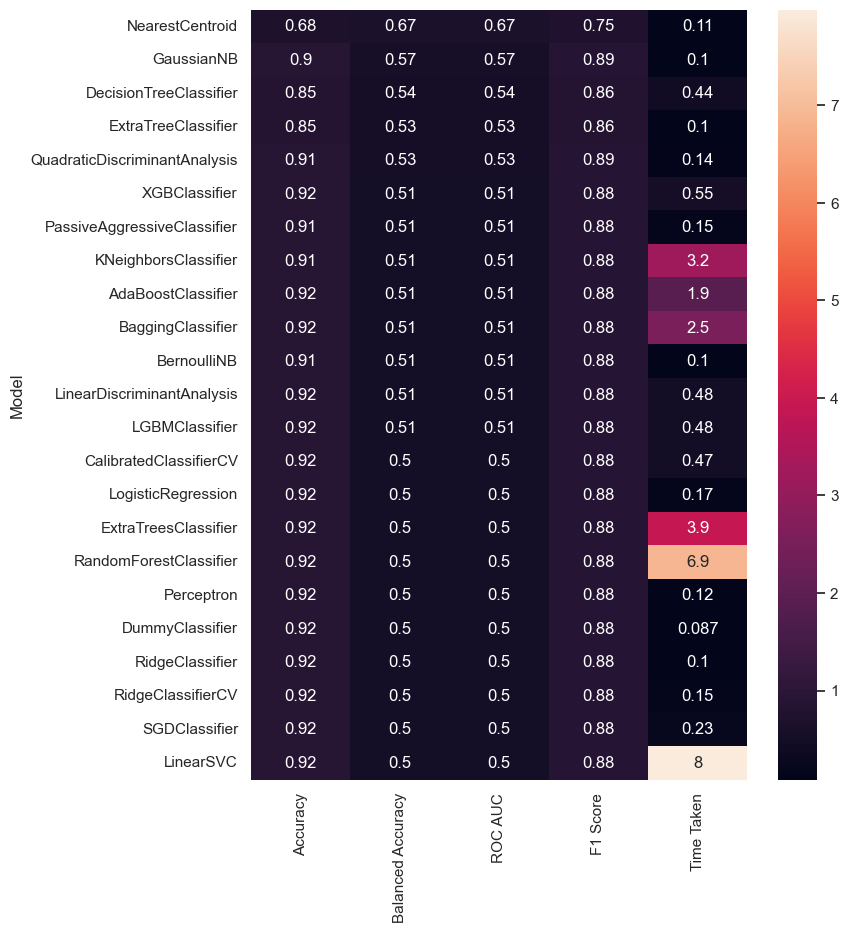

In [19]:
plt.figure(figsize=(8, 10))

sns.heatmap(classif_models[(classif_models['Time Taken'] < 10)], annot=True)
plt.show()